# Integrating Product Design and Supply Chain Design

## Import Packages

In [126]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc

## Parameters

In [127]:
numAssemblyOptions = 2
numSuppliersPerPart = 2

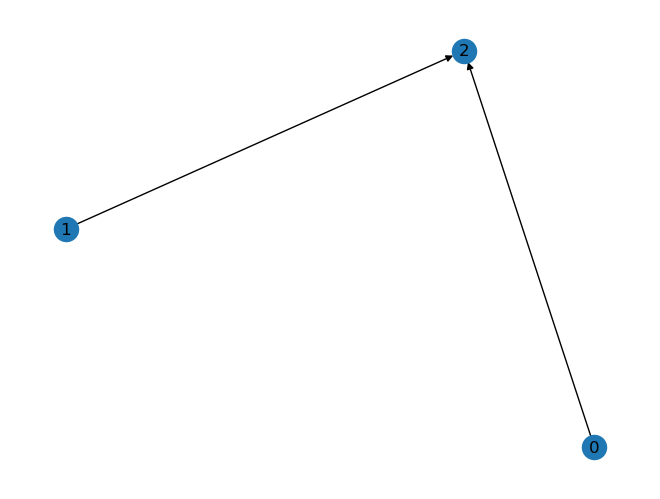

In [128]:
G = nx.DiGraph()

numProcureNodes = 2
numAssemblyNodes = 0
numNodes = numProcureNodes + numAssemblyNodes + 1

procureNodes = list(range(numProcureNodes))
finalNode = numNodes - 1

numOptions = 2

np.random.seed(0)

maxServiceTimeOut = 20

processTimes = [1, 2, 1]

G.add_node(finalNode, process_time=processTimes[finalNode], 
            max_service_time_out=0)

for n in procureNodes:
    G.add_node(n, process_time=processTimes[n], 
               max_service_time_out=20)
    G.add_edge(n, finalNode)

processTimesDict = nx.get_node_attributes(G, 'process_time')
maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
    
nx.draw(G, with_labels=True)
plt.show()

In [129]:
safetyFactor = 1.5
sigma = 3

maxReplenishmentTime = {}

for n in procureNodes:
    maxReplenishmentTime[n] = processTimesDict[n]

maxReplenishmentTime[finalNode] = processTimesDict[finalNode] + max([maxReplenishmentTime[n] for n in procureNodes])

def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn(node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if node == finalNode:
        maxVal = min(maxVal, maxServiceTimeOut[finalNode])
    return range(maxVal + 1)

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*np.sqrt(sIn + processTimesDict[node] - sOut)

def create_dp_graph(G : nx.DiGraph):
    nNodes = len(G.nodes())
    finalNode = nNodes - 1
    dp_G = nx.DiGraph()
    #sink = finalNode + 1
    dp_G.add_node('t')
    for sIn in get_sIn_range_for_g_fn(finalNode):
        for sOut in get_sOut_range_for_g_fn(finalNode, sIn):
            finalNodeTuple = (finalNode, sOut, sIn)
            dp_G.add_node(finalNodeTuple)
            dp_G.add_edge(finalNodeTuple, 't', 
                        cost = getHoldingCost(finalNode, sIn, sOut))
            # n = 0
            # for sOut in get_sOut_range(n):
            #     nodeTuple = (n, sIn2, sOut)
            #     dp_G.add_edge('s', nodeTuple, cost = 0)
            #     dp_G.add_node(nodeTuple)
            #     dp_G.add_edge(nodeTuple, finalNodeTuple, 
            #                     cost = getHoldingCost(n, sIn2, sOut))


    return dp_G

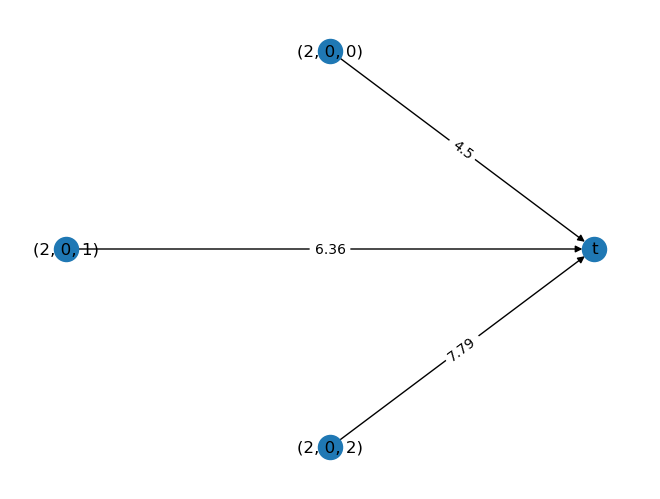

In [130]:
dp_G = create_dp_graph(G)

pos = nx.circular_layout(dp_G)
nx.draw(dp_G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(dp_G, 'cost')
edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [131]:
start_node = 's'  # replace with your start node
end_node = 't'  # replace with your end node

path = nx.shortest_path(dp_G, start_node, end_node, weight='cost')

print(path)

NodeNotFound: Either source s or target t is not in G